In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pySAMetrics
import matplotlib.pyplot as plt
from pySAMetrics.Simulation import Simulation
from pySAMetrics.utils import generate_simulation_paths
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
simu_list=[]

### add control case
# Example usage
velocity = '0'
temperature='300'
bowen_ratio='1'
microphysic='1'

def get_paths(i):
    paths = {
    'path_3d': f'/home/ec2-user/DeepCloudLab/outputs/RCE_splits_v2/3D/split_{i+1}.nc',
    'path_2d': f'/home/ec2-user/DeepCloudLab/outputs/RCE_splits_v2/2D/split_{i+1}.nc',
    'path_1d': f'/home/ec2-user/DeepCloudLab/outputs/RCE_splits_v2/1D/split_{i+1}.nc'
    }
    return paths

for i in range(10):
    paths=get_paths(i)
    simu = Simulation(data_folder_paths=[paths['path_1d'], paths['path_2d'], paths['path_3d']],
                    velocity=velocity,
                    temperature=temperature,
                    bowen_ratio=bowen_ratio,
                    microphysic=microphysic)

    simu.load(backup_folder_path=f'/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_{i}')
    simu_list.append(simu)

****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_0/RCE_T300_U0_B1_M1
****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_1/RCE_T300_U0_B1_M1
****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_2/RCE_T300_U0_B1_M1
****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_3/RCE_T300_U0_B1_M1
****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_4/RCE_T300_U0_B1_M1
****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_5/RCE_T300_U0_B1_M1
B No dataset found: dataset_computed_2d
****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_6/RCE_T300_U0_B1_M1
B No dataset found: dataset_computed_2d
****/home/ec2-user/DeepCloudLab/processed_classes/long_run_RCE_T300_U0_B1_M1_split_7/RCE_T300_U0_B1_M1
B No dataset found: dataset_computed_2d
****/home/ec2-user/DeepCloudLab/processed_classes/long_r

In [5]:
[simu.name for simu in simu_list]

['RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1',
 'RCE_T300_U0_B1_M1']

In [113]:
from pySAMetrics.diagnotic_fmse import find_most_variable_subdomain_via_filter_fast, subdomain_indices, diagnostic_fmse_z

In [111]:
nx_sub, ny_sub = 64, 64
nx, ny = 128, 128
all_sub_indices_simu=[]
for i_simu in tqdm(range(6)):
    fmse_array = simu_list[i_simu].dataset_computed_3d.FMSE.values
    all_sub_indices = []
    for t in tqdm(range(480)):
        all_sub_indices.append([])
        fmse_array_i = fmse_array[t]
        for z_idx in range(64):
            fmse_slice = fmse_array_i[z_idx]
            (x_center, y_center), _ =find_most_variable_subdomain_via_filter_fast(array_2d=fmse_slice, nx_sub=nx_sub, ny_sub=ny_sub,  pad=3)
            sub = subdomain_indices(x_center, y_center, nx_sub, ny_sub, nx, ny)
            all_sub_indices[-1].append(sub)
    all_sub_indices_simu.append(all_sub_indices)

100%|██████████| 6/6 [02:51<00:00, 28.52s/it]


In [112]:
all_sub_indices_simu=np.array(all_sub_indices_simu)

In [117]:
all_diag_reduced_simu=[]
for i_simu in tqdm(range(6)):
    all_sub_indices = all_sub_indices_simu[i_simu]
    fmse_array = simu_list[i_simu].dataset_computed_3d.FMSE.values
    rho_w_array = simu_list[i_simu].dataset_computed_3d.RHO_W.values
    fmse_sub = np.zeros((480, 64, nx_sub, ny_sub))
    rho_w_sub = np.zeros((480, 64, nx_sub, ny_sub))

    for t in tqdm(range(480)):
        for z in range(64):
            fmse_select = fmse_array[t, z][np.ix_(all_sub_indices[t, z,0],all_sub_indices[t, z,1])]
            fmse_sub[t, z]=fmse_select

            rho_w_select = rho_w_array[t, z][np.ix_(all_sub_indices[t, z,0],all_sub_indices[t, z,1])]
            rho_w_sub[t, z]=rho_w_select
    diag_reduces_i_simu =[]
    for i_t in tqdm(range(480)):
        diag_reduced_window = diagnostic_fmse_z(
            fmse_array=fmse_sub,
            z_array=simu_list[i_simu].dataset_3d.z.values,
            data_array=rho_w_sub,
            time_step=i_t,
            bin_mode='max'
        )
        diag_reduces_i_simu.append(diag_reduced_window)
    diag_reduces_i_simu = np.array(diag_reduces_i_simu)
    all_diag_reduced_simu.append(diag_reduces_i_simu)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [07:15<00:00, 72.52s/it]


In [119]:
all_diag_reduced_simu = np.array(all_diag_reduced_simu)

In [124]:
n_sim, nt, nz, nf = all_diag_reduced_simu.shape

In [125]:
reshaped_data = all_diag_reduced_simu.reshape(n_sim*nt, nz*nf)

In [175]:
import numpy as np

# Reshape and replace NaN values with zeros (or another fill value)
reshaped_data = np.nan_to_num(reshaped_data)
print('Shape:', reshaped_data.shape)

# Compute mean and std across the correct axis
mean_norm_data = reshaped_data.mean(axis=0)
std_norm_data = reshaped_data.std(axis=0)

print('Mean:', mean_norm_data.shape)
print('Mean overall:', reshaped_data.mean())
print('Std overall:', reshaped_data.std())

# Avoid division by zero by adding a small epsilon to std when it's zero
epsilon = 1e-10
std_norm_data = np.where(std_norm_data == 0, epsilon, std_norm_data)

# Normalize the data
#reshaped_data = (reshaped_data - mean_norm_data) / std_norm_data


# Reshape the data as needed (back to 2D form if necessary)
reshaped_data = reshaped_data.reshape((reshaped_data.shape[0], -1))

print('Normalized data shape:', reshaped_data.shape)


Shape: (2880, 3200)
Mean: (3200,)
Mean overall: 8.881784197001253e-19
Std overall: 0.5801400692936148
Normalized data shape: (2880, 3200)


In [218]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming reshaped_data is of shape (n_im, n_dim)
# Number of clusters (k) can be adjusted depending on your use case
n_clusters = 3  # Example for 2 clusters

#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(reshaped_data)


# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)



# Fit the model to your reshaped image data
kmeans.fit(reshaped_data)

# Get the cluster labels for each image
cluster_labels = kmeans.labels_

# If you want to inspect the cluster centers
cluster_centers = kmeans.cluster_centers_

# Print the cluster labels
print(f'Cluster labels: {cluster_labels}')

# Optionally: reshape the labels to match the original image format for visualization
# Example: Assuming each image was originally 2D (height, width)
# For each image, you can now inspect which cluster it belongs to


Cluster labels: [1 1 1 ... 2 2 2]


In [219]:
np.unique(cluster_labels)

array([0, 1, 2], dtype=int32)

In [220]:
np.where(cluster_labels==0), np.where(cluster_labels==1), 

((array([ 140, 1580]),), (array([   0,    1,    2, ..., 2870, 2871, 2872]),))

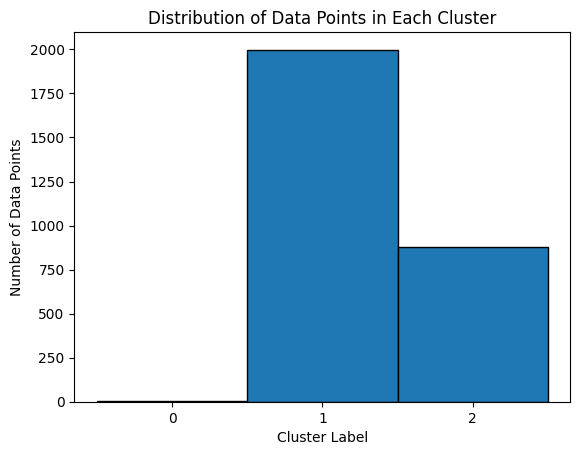

In [221]:
import matplotlib.pyplot as plt

# Plot a histogram of the cluster labels
plt.hist(cluster_labels, bins=[0, 1, 2,3], edgecolor='black', align='left')

# Add labels and title
plt.title('Distribution of Data Points in Each Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')

plt.xticks([0, 1,2])  # Ensure the x-axis ticks match the clusters

plt.show()

In [222]:
[len(np.where(cluster_labels==i)[0]) for i in range(n_clusters)]

[2, 1998, 880]

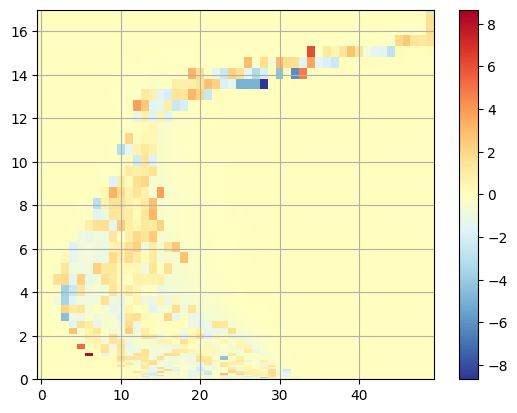

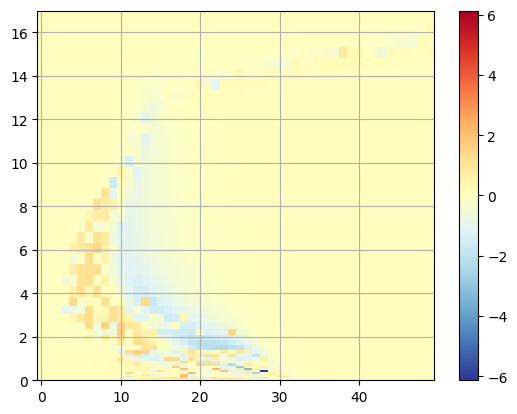

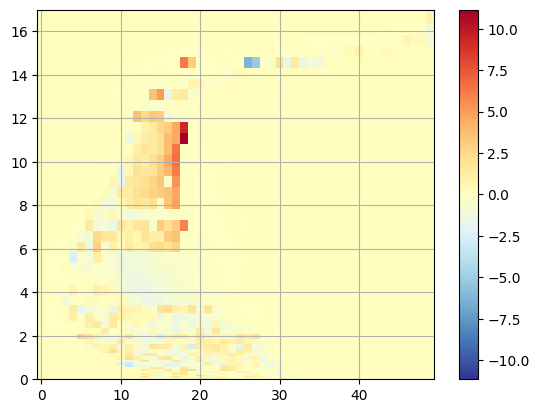

In [230]:
fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[1].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
for idx in [np.where(cluster_labels==i)[0][0] for i in range(n_clusters)]:
    data = reshaped_data[idx].reshape(64,50)
    plt.pcolormesh(XX,ZZ,data ,cmap='RdYlBu_r', vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))#, vmin=-2, vmax=2)
    plt.colorbar()
    plt.grid(True)
    plt.ylim(0,17)
    plt.show()


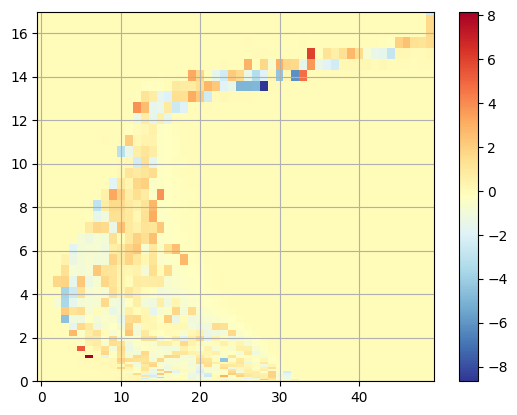

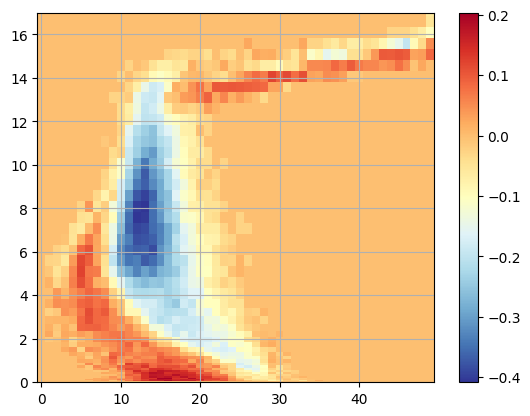

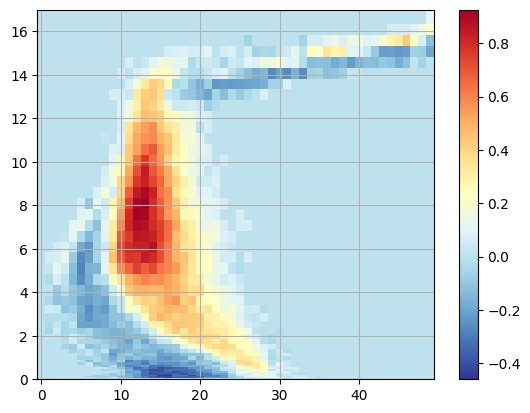

In [224]:
fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[1].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
for center in cluster_centers:
    plt.pcolormesh(XX,ZZ, center.reshape(64,50),cmap='RdYlBu_r')#, vmin=-2, vmax=2)
    plt.colorbar()
    plt.grid(True)
    plt.ylim(0,17)
    plt.show()


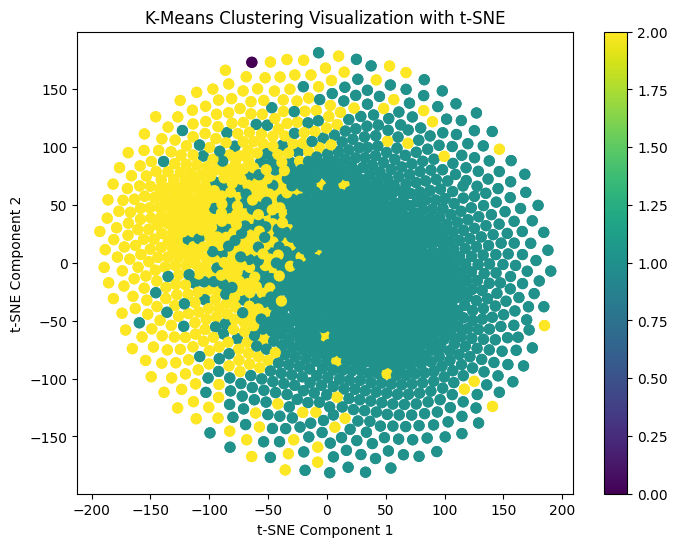

In [225]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(reshaped_data)

# Plot the t-SNE reduced data
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=cluster_labels, cmap='viridis', s=50)

# Add labels and title for clarity
plt.colorbar()  # Show the color scale of clusters
plt.title('K-Means Clustering Visualization with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()


In [127]:
# Set the split percentages
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Calculate split indices
total_samples = reshaped_data.shape[0]
train_size = int(train_split * total_samples)
val_size = int(val_split * total_samples)
test_size = total_samples - train_size - val_size

# Shuffle the data (optional, but common in dataset splitting)

#indices = np.random.permutation(total_samples)
indices = np.arange(total_samples) #no permutation because we need time coherence
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split the data
train_data = reshaped_data[train_indices]
val_data = reshaped_data[val_indices]
test_data = reshaped_data[test_indices]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

# Create DataLoaders for batching during training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [128]:
class KoopmanOperator(nn.Module):
    def __init__(self, input_dim, hidden_dim, koopman_dim):
        super(KoopmanOperator, self).__init__()
        # Encoder: projects the data into a latent space where Koopman dynamics are linear
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 100),
            nn.ReLU(),
            nn.Linear(100, koopman_dim)
        )
        # Koopman matrix: learned linear operator in the latent space
        self.koopman_matrix = nn.Linear(koopman_dim, koopman_dim, bias=False)
        # Decoder: projects the latent space back to the original space
        self.decoder = nn.Sequential(
            nn.Linear(koopman_dim, 100),
            nn.ReLU(),
            nn.Linear(100, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        # Encode to latent space
        latent = self.encoder(x)
        # Apply Koopman operator (linear dynamics in latent space)
        latent_next = self.koopman_matrix(latent)
        # Decode back to the original space
        x_next = self.decoder(latent_next)
        return latent, latent_next, x_next

In [149]:
_, input_dim = reshaped_data.shape

# Instantiate the VAE
dict_koopman={'input_dim':input_dim, 'hidden_dim':500, 'koopman_dim':25}

model = KoopmanOperator(**dict_koopman)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)

def masked_mse_loss(pred, target):
    # Create a mask that identifies non-zero elements in the target
    mask = target != 0
    # Compute MSE loss only where the mask is True (non-zero values)
    criterion = nn.MSELoss()
    return criterion(pred[mask], target[mask])

In [150]:
# Early stopping parameters
patience = 50  # Number of epochs to wait for improvement before stopping
min_delta = 0  # Minimum change to qualify as an improvement
best_val_loss = float('inf')  # Initialize to infinity
patience_counter = 0  # Count how long the validation loss hasn't improved

# Training loop
epochs = 500
criterion = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x = batch[0][:-4]
        x_next = batch[0][4:]

        optimizer.zero_grad()
        latent, latent_next_pred, x_next_pred = model(x)
        latent_next = model.encoder(x_next)
        
        # Loss components
        loss_reconstruction = masked_mse_loss(x_next, x_next_pred)
        loss_autoencoder = masked_mse_loss(x, model.decoder(latent))
        loss_koopman = criterion(latent_next_pred, latent_next)  # Enforce Koopman dynamics
        koopman_mat = model.koopman_matrix.weight  # Access Koopman matrix
        loss_regularization = torch.norm(koopman_mat-koopman_mat.transpose(0, 1), p='fro')
        loss = loss_reconstruction + loss_koopman +loss_regularization + loss_autoencoder
        #loss = loss_reconstruction + loss_koopman + loss_autoencoder
        print(f"Epoch {epoch+1}/{epochs}, Loss: rec{loss_reconstruction}, koop{loss_koopman}, rg{loss_regularization},auto{loss_autoencoder}, tot{loss}", end="\r")


        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}", end="\r")
    # Validation step
    model.eval()  # Set VAE to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_batch in val_loader:
            x_val = batch[0][:-4]
            x_val_next = batch[0][4:]

            latent_val, latent_val_next_pred, x_val_next_pred = model(x_val)
            latent_val_next = model.encoder(x_val_next)
            
            # Loss components
            loss_reconstruction_val = masked_mse_loss(x_val_next, x_val_next_pred)
            loss_koopman_val = criterion(latent_val_next_pred, latent_val_next)  # Enforce Koopman dynamics
            loss_autoencoder_val = masked_mse_loss(x_val, model.decoder(latent_val))
            koopman_mat = model.koopman_matrix.weight  # Access Koopman matrix
            loss_regularization_val = torch.norm(koopman_mat-koopman_mat.transpose(0, 1), p=1)
            loss_val = loss_reconstruction_val + loss_koopman_val + loss_regularization_val +loss_autoencoder_val
            #loss_val = loss_reconstruction_val + loss_koopman_val +loss_autoencoder_val
            total_val_loss += loss_val.item()
    
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}",end="\r")

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
    
    # Check if patience limit is reached
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


# Ensure the final epoch result is printed properly
print(f"Training Complete. Final Loss: {total_loss / len(train_loader.dataset):.4f}")



Early stopping triggered at epoch 14547546, koop0.0012764416169375181, rg8.754969167057425e-05,auto0.4239133894443512, tot0.993440508842468387537
Training Complete. Final Loss: 0.0202


In [151]:
model.eval()  # Set VAE to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of images from the DataLoader
data_iter = iter(test_loader)  # Create an iterator for the DataLoader
images = next(data_iter)  # Get a batch of images

# Since there's only one tensor in the dataset, access it with [0]
images = images[0].to(device)  # Move to GPU if available


# Pass the images through the VAE
with torch.no_grad():
    latent, _, reconstructed_images =  model(images)  # Decode the images
    reconstructed_images2 = model.decoder(latent)
    reconstructed_images2 = reconstructed_images2.reshape(32, nz, nf)

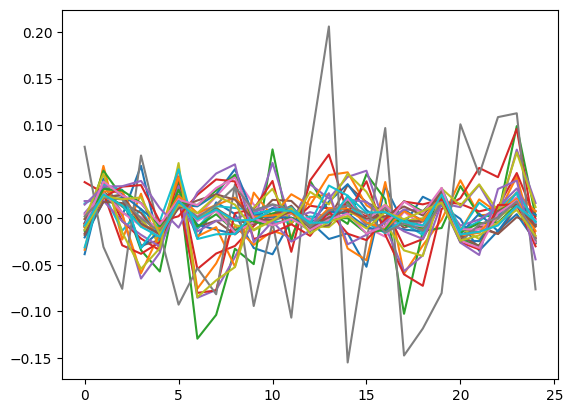

In [152]:
for i_img in range(30):
    plt.plot(latent[i_img])
plt.show()

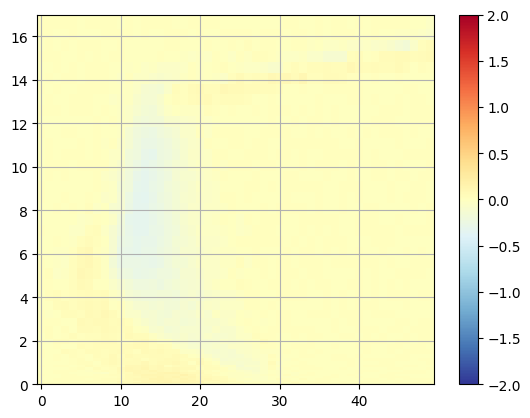

In [155]:

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
reconstructed_scale_image=reconstructed_images2[i_img]
plt.pcolormesh(XX,ZZ, reconstructed_scale_image,cmap='RdYlBu_r', vmin=-2, vmax=2)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)
plt.show()

(0.0, 17.0)

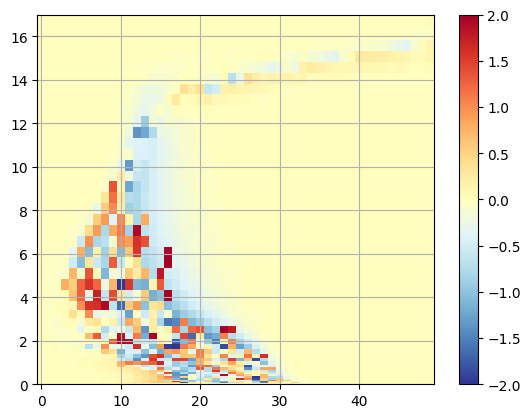

In [156]:

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
plt.pcolormesh(XX,ZZ, images[i_img].reshape(64, 50),cmap='RdYlBu_r', vmin=-2, vmax=2)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)


(0.0, 17.0)

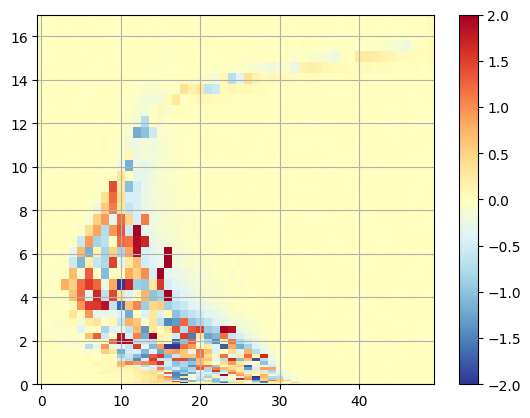

In [157]:

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
plt.pcolormesh(XX,ZZ, images[i_img].reshape(64, 50)-reconstructed_images2[i_img], cmap='RdYlBu_r', vmin=-2, vmax=2)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)
#plt.clim(-1,1)

In [138]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from pySAMetrics import config
from scipy.ndimage import generic_filter, uniform_filter
from tqdm import tqdm
from joblib import Parallel, delayed  # For parallelization


def variance_filter(array, nx_sub, ny_sub):
    """Apply a variance filter over the image with a window size of (nx_sub, ny_sub)."""
    return generic_filter(array, np.var, size=(nx_sub, ny_sub))

def find_most_variable_subdomain_via_filter(array_2d, nx_sub, ny_sub, pad=10):
    """Find the subdomain of size (nx_sub, ny_sub) with the strongest variability using a filter."""
    # Apply padding to the array
    padded_array = np.pad(array_2d, pad_width=pad, mode='constant', constant_values=0)
    
    # Apply a variance filter over the padded array
    variability_map = variance_filter(padded_array, nx_sub, ny_sub)
    
    # Optionally, crop back to the original array size if needed (removing padding)
    cropped_variability_map = variability_map[pad:-pad, pad:-pad]
    
    # Find the coordinates of the maximum variability in the cropped map
    max_coords = np.unravel_index(np.argmax(cropped_variability_map), cropped_variability_map.shape)
    
    return max_coords, cropped_variability_map

def variance_filter_fast_with_padding(array, nx_sub, ny_sub, pad=1):
    """Apply a faster variance filter over the image using uniform_filter, with padding."""
    # Pad the array to simulate the behavior of the generic_filter pad
    padded_array = np.pad(array, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)
    
    # Compute the mean in the nx_sub by ny_sub window
    mean = uniform_filter(padded_array, size=(nx_sub, ny_sub))
    
    # Compute the mean of the squared values in the window
    mean_of_squares = uniform_filter(padded_array**2, size=(nx_sub, ny_sub))
    
    # Variance is E[x^2] - (E[x])^2
    variance = mean_of_squares - mean**2
    
    # Return the valid part of the result (exclude padded areas)
    return variance[pad:-pad, pad:-pad]

def find_most_variable_subdomain_via_filter_fast(array_2d, nx_sub, ny_sub, pad=1):
    """Find the subdomain with the strongest variability using a fast filter."""
    # Apply a fast variance filter over the array
    variability_map = variance_filter_fast_with_padding(array_2d, nx_sub, ny_sub, pad=pad)
    
    # Find the coordinates of the maximum variability
    max_coords = np.unravel_index(np.argmax(variability_map), variability_map.shape)
    
    return max_coords, variability_map

def subdomain_indices(x_center, y_center, nx_sub, ny_sub, nx, ny):
        
        # Calculate the subdomain indices considering periodic boundaries
        x_indices = (np.arange(x_center - nx_sub // 2, x_center + nx_sub // 2) % nx)
        y_indices = (np.arange(y_center - ny_sub // 2, y_center + ny_sub // 2) % ny)
        
        return x_indices, y_indices

def extract_periodic_subdomain(array,x_indices,y_indices ):
    """
    Extracts a subdomain from a doubly periodic domain around a given center.
    
    Parameters:
    - array: 2D array (image) from which to extract the subdomain.
    - x_center: The x-coordinate of the center of the subdomain.
    - y_center: The y-coordinate of the center of the subdomain.
    - nx_sub: The width of the subdomain.
    - ny_sub: The height of the subdomain.

    Returns:
    - subdomain: The extracted subdomain as a 2D array.
    """
    
    # Extract the subdomain
    subdomain = array[np.ix_(x_indices, y_indices)]
    
    return subdomain



In [7]:
nx_sub, ny_sub = 64, 64
nx, ny = 128, 128
fmse_array = simu_list[0].dataset_computed_3d.FMSE.values

In [9]:

all_sub_indices = []
for t in tqdm(range(480)):
    all_sub_indices.append([])
    fmse_array_i = fmse_array[t]
    for z_idx in range(64):
        fmse_slice = fmse_array_i[z_idx]
        (x_center, y_center), _ =find_most_variable_subdomain_via_filter_fast(array_2d=fmse_slice, nx_sub=nx_sub, ny_sub=ny_sub,  pad=3)
        sub = subdomain_indices(x_center, y_center, nx_sub, ny_sub, nx, ny)
        all_sub_indices[-1].append(sub)

 22%|██▏       | 105/480 [00:03<00:12, 29.34it/s]

100%|██████████| 480/480 [00:16<00:00, 29.04it/s]


In [10]:
all_sub_indices = np.array(all_sub_indices)

In [11]:
all_sub_indices.shape

(480, 64, 2, 64)

In [12]:
rho_w_array = simu_list[0].dataset_computed_3d.RHO_W.values

In [13]:
nt=480
nz=64
fmse_sub = np.zeros((nt, nz, nx_sub, ny_sub))
rho_w_sub = np.zeros((nt, nz, nx_sub, ny_sub))

for t in tqdm(range(480)):
    for z in range(64):
        fmse_select = fmse_array[t, z][np.ix_(all_sub_indices[t, z,0],all_sub_indices[t, z,1])]
        fmse_sub[t, z]=fmse_select

        rho_w_select = rho_w_array[t, z][np.ix_(all_sub_indices[t, z,0],all_sub_indices[t, z,1])]
        rho_w_sub[t, z]=rho_w_select


100%|██████████| 480/480 [00:03<00:00, 131.69it/s]


In [14]:
fmse_sub.shape, rho_w_sub.shape

((480, 64, 64, 64), (480, 64, 64, 64))

In [19]:
def periodic_distance(A, B, Lx=128, Ly=128):
    """Compute the periodic squared distance between arrays of points A and B."""
    # Ensure that A and B are numpy arrays
    A = np.asarray(A)
    B = np.asarray(B)
    
    # Extract the x and y coordinates of each point
    x1, y1 = A[:, 0], A[:, 1]
    x2, y2 = B[:, 0], B[:, 1]

    # Calculate the differences in x and y
    dx = np.abs(x1 - x2)
    dy = np.abs(y1 - y2)

    # Apply periodic boundary conditions
    dx = np.minimum(dx, Lx - dx)
    dy = np.minimum(dy, Ly - dy)
    # Return the squared distance
    return np.sqrt(dx**2 + dy**2)

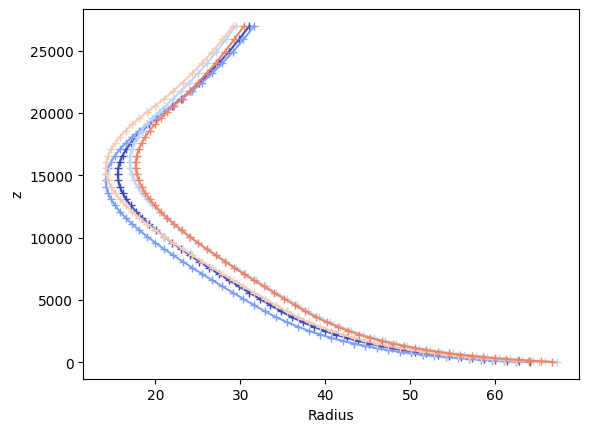

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define your domain size (assuming square grid for simplicity)
Lx, Ly = 128, 128  # Modify this according to your domain size

# Define the colormap from deep blue to light blue
cmap = plt.get_cmap('coolwarm')  # Built-in colormap from deep blue to light blue
z = simu_list[0].dataset_3d.z.values
N_t = 5
for i in range(N_t):
    # Get the coordinates for the i-th index, for example
    x1, y1 = all_sub_indices[i, :, 0][32], all_sub_indices[i, :, 1][32]
    
    # Define A as a set of zeros (representing the origin for all points)
    A = np.zeros((len(x1), 2))  # Create an array of zeros, one for each point
    B = np.column_stack((x1, y1))  # Stack x1 and y1 to create a 2D array
    
    # Compute the periodic distances
    radius = periodic_distance(A, B)
    
    # Plot the radius against z, with color depending on time
    im = plt.plot(radius, z,  '+-',color=cmap(i/N_t))
    
# Display the plot with color bar
#plt.ylim(0, 10)
plt.xlabel('Radius')
plt.ylabel('z')
plt.show()


In [24]:
def diagnostic_fmse_z(
    fmse_array: np.array,
    z_array: np.array,
    data_array: np.array,
    time_step: int,
    nb_bins_fmse: int = 50,
    fmse_range: str = "max",
    bin_mode='sum'
):

    if type(data_array) not in [
        list,
        np.array,
        xr.core.dataarray.DataArray,
        np.ndarray,
    ]:
        raise ValueError(
            "data_array type is not standard, must be in [list, np.array, xarray.core.dataarray.DataArray, np.ndarray,]"
        )

    if type(data_array) not in [
        list,
        np.array,
        np.ndarray,
    ]:
        data_array = data_array.values

    if fmse_range not in ["max", "1-percentile"]:
        raise ValueError("fmse_range must be in [max, 1_percentile]")

    nz = z_array.shape[0]
    output_matrix = np.zeros((nz, nb_bins_fmse))

    data_array_i = data_array[time_step]
    fmse_array_i = fmse_array[time_step]

    if fmse_range == "max":
        total_min, total_max = (np.min(fmse_array_i), np.max(fmse_array_i))

    if fmse_range == "1-percentile":
        total_min, total_max = (np.percentile(fmse_array_i, 1), np.percentile(fmse_array_i, 99))

    total_range = np.linspace(config.FMSE_MIN, config.FMSE_MAX, nb_bins_fmse)

    fmse_array_i[fmse_array_i>config.FMSE_MAX]=config.FMSE_MAX
    fmse_array_i[fmse_array_i<config.FMSE_MIN]=config.FMSE_MIN




    for zz in range(nz - 1):

        ind_xy = np.array(
            [
                np.where(
                    np.logical_and(
                        total_range[i] <= fmse_array_i[zz],
                        fmse_array_i[zz] <= total_range[i + 1],
                    )
                )
                for i in range(total_range.shape[0] - 1)
            ],
            dtype="object",
        )

        # I expect to see RuntimeWarnings in this block
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            #foo = np.nanmean(x, axis=1)
        
        value_zz_fmse=[]
        for i in range(len(ind_xy)):
            arr = data_array_i[zz, ind_xy[i][0], ind_xy[i][1]]
            if len(arr>0):
                #mean_value_zz_fmse.append(arr[np.argmax(np.absolute(arr))])
                if bin_mode=='sum':
                    value_zz_fmse.append(np.sum(arr))
                elif bin_mode=='mean':
                    value_zz_fmse.append(np.mean(arr))
                elif bin_mode=='max':
                    value_zz_fmse.append(arr[np.argmax(np.absolute(arr))])

            else:
                value_zz_fmse.append(np.nan)

        output_matrix[zz, 1:] = value_zz_fmse

    return output_matrix



In [25]:
print(fmse_array.shape, fmse_sub.shape)

(480, 64, 128, 128) (480, 64, 64, 64)


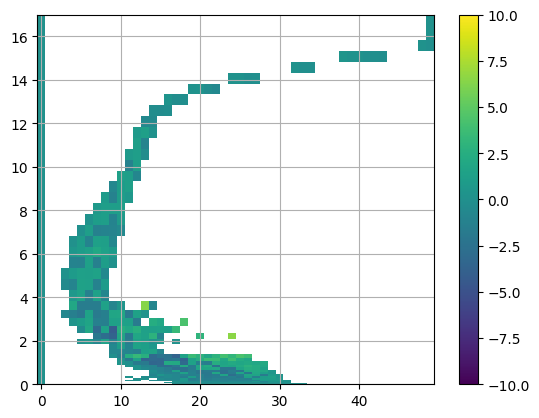

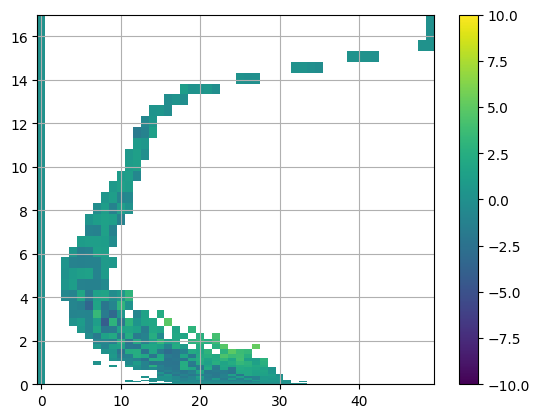

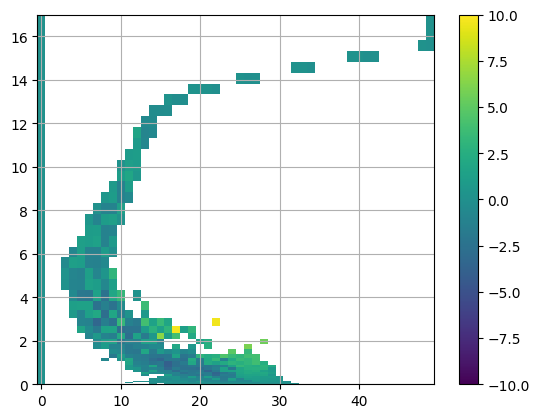

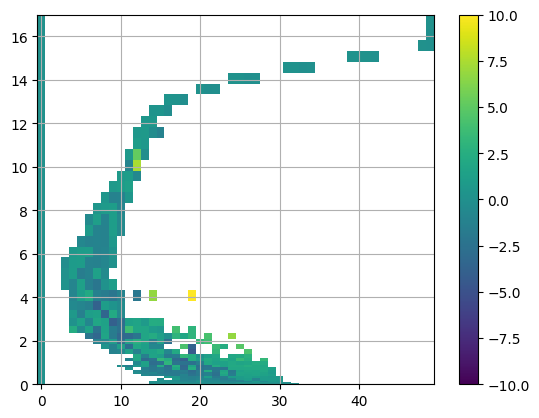

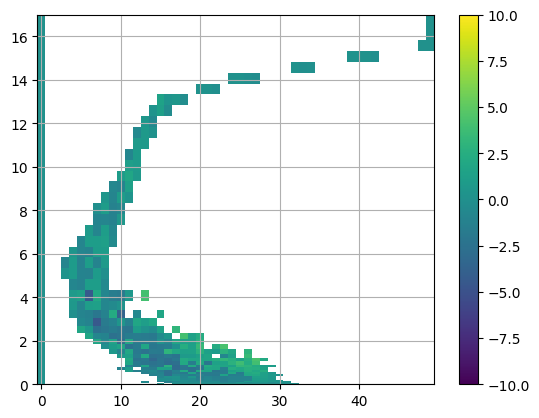

In [31]:

fmse = simu_list[0].dataset_isentropic.fmse.values
z = simu_list[0].dataset_3d.z.values / 1000
for i in range(5):
    diag_before = diagnostic_fmse_z(
        fmse_array=fmse_array,
        z_array=simu_list[0].dataset_3d.z.values,
        data_array=rho_w_array,
        time_step=i,
        bin_mode='max')

    diag_reduced_window = diagnostic_fmse_z(
        fmse_array=fmse_sub,
        z_array=simu_list[0].dataset_3d.z.values,
        data_array=rho_w_sub,
        time_step=i,
        bin_mode='max'
    )
    """
    fmse = simu_list[0].dataset_isentropic.fmse.values
    z = simu_list[0].dataset_3d.z.values / 1000
    XX, ZZ = np.meshgrid(fmse, z)
    plt.pcolormesh(XX,ZZ, diag_before)
    plt.ylim(0,17)
    plt.grid(True)
    plt.show()
    """
    XX, ZZ = np.meshgrid(fmse, z)
    plt.pcolormesh(XX,ZZ, diag_reduced_window, vmin=-10, vmax=10)
    plt.ylim(0,17)
    plt.colorbar()
    plt.grid(True)
    plt.show()

In [235]:
all_diag_reduced_window=[]
for i in range(480):
    diag_reduced_window = diagnostic_fmse_z(
        fmse_array=fmse_sub,
        z_array=simu_list[0].dataset_3d.z.values,
        data_array=rho_w_sub,
        time_step=i,
        bin_mode='sum'
    )
    all_diag_reduced_window.append(diag_reduced_window)

In [236]:
all_diag_reduced_window=np.array(all_diag_reduced_window)

In [237]:
all_diag_reduced_window_no_nan = np.nan_to_num(all_diag_reduced_window)

In [239]:
mean_diag = np.mean(all_diag_reduced_window_no_nan, axis=0)
std_diag = np.std(all_diag_reduced_window_no_nan, axis=0)
std_diag[std_diag==0]=0.00001
mean_diag2 = mean_diag
mean_diag2[mean_diag==0]=np.nan

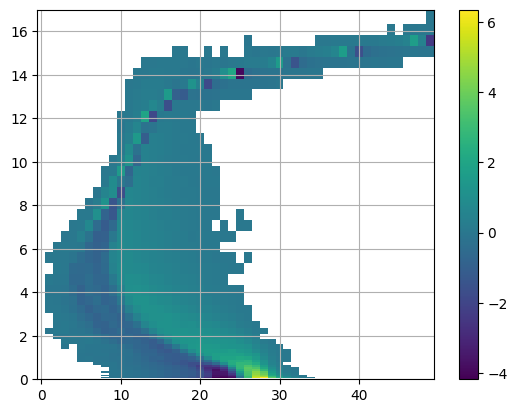

In [240]:

fmse = simu_list[0].dataset_isentropic.fmse.values
z = simu_list[0].dataset_3d.z.values / 1000
XX, ZZ = np.meshgrid(fmse, z)
plt.pcolormesh(XX,ZZ, mean_diag/std_diag)#, vmin=-10, vmax=10)
plt.ylim(0,17)
plt.colorbar()
plt.grid(True)
plt.show()

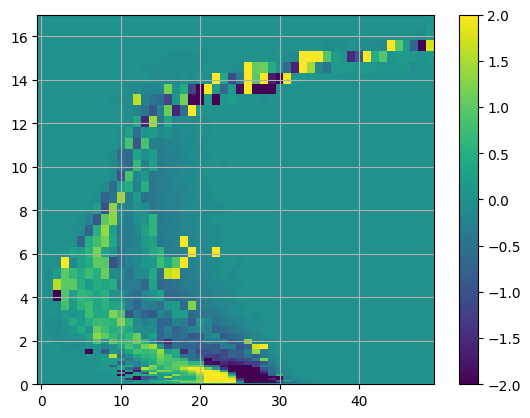

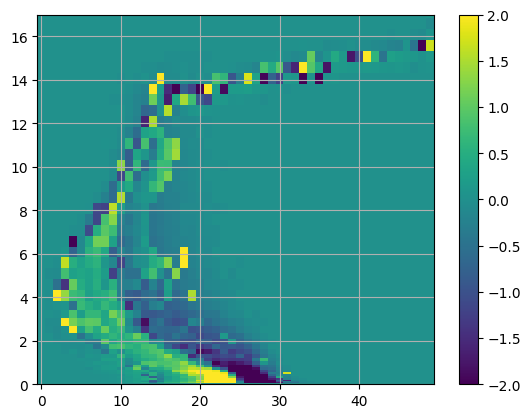

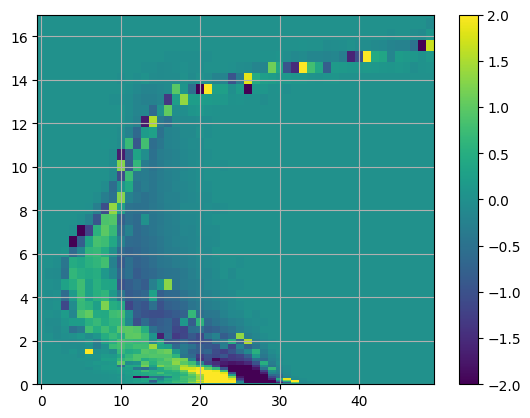

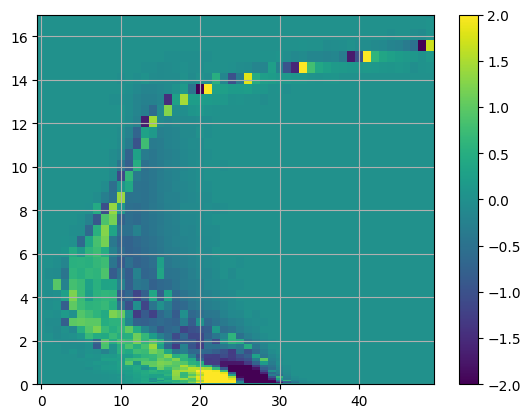

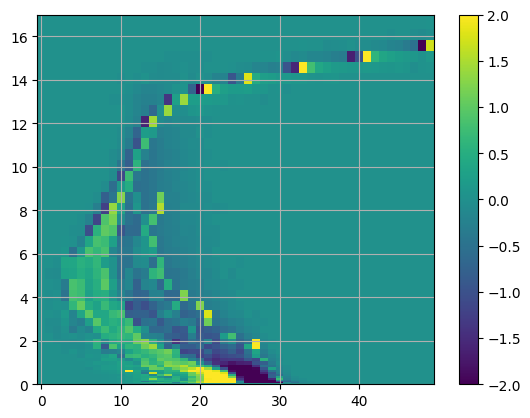

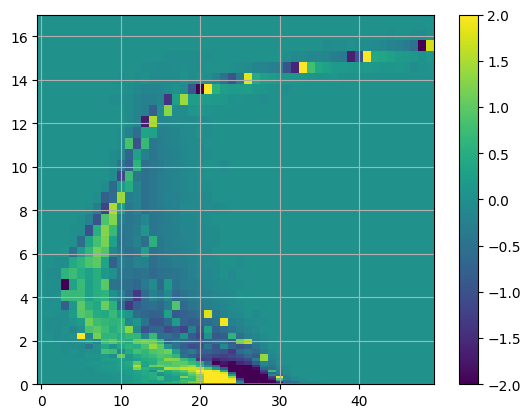

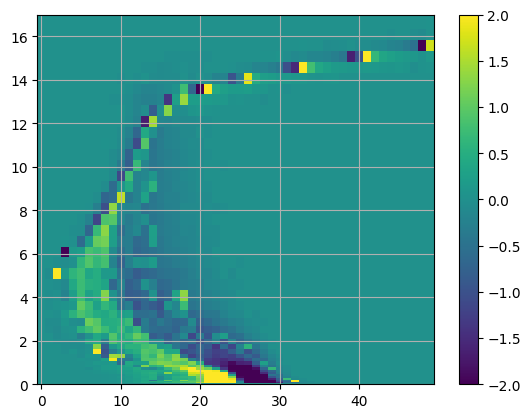

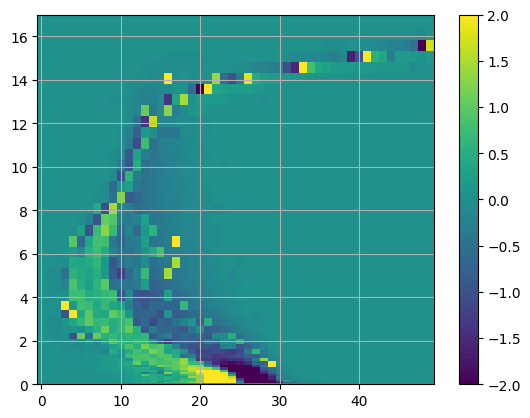

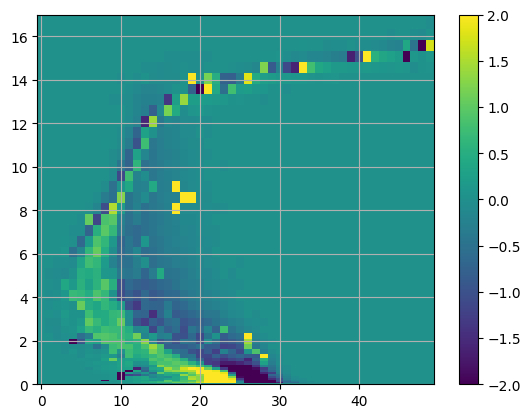

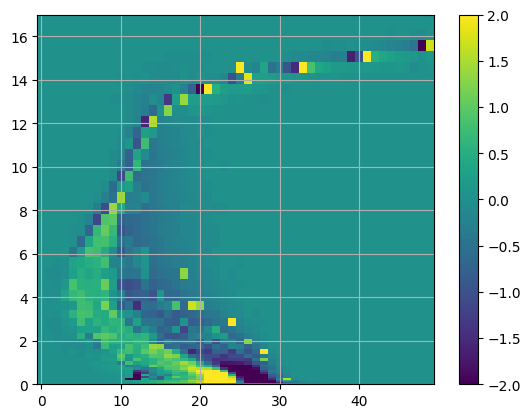

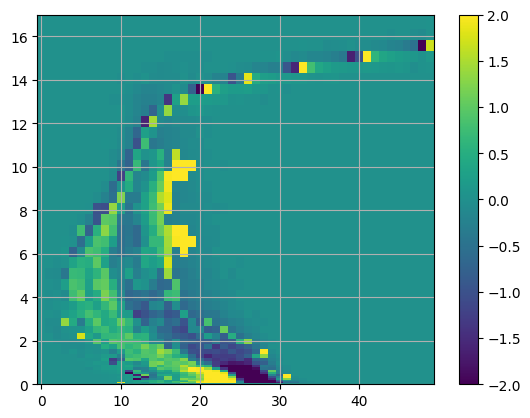

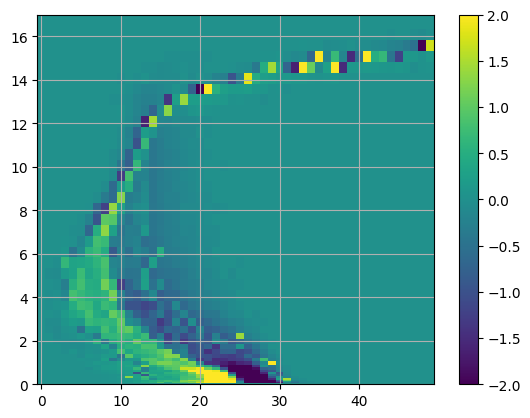

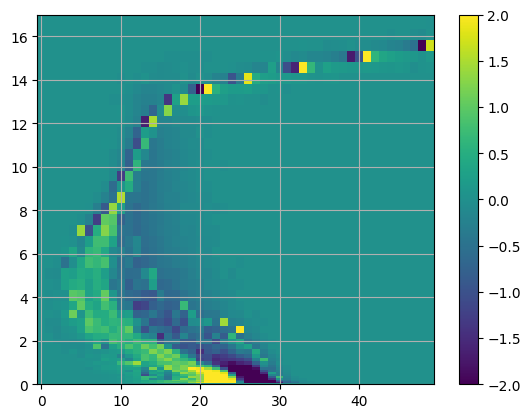

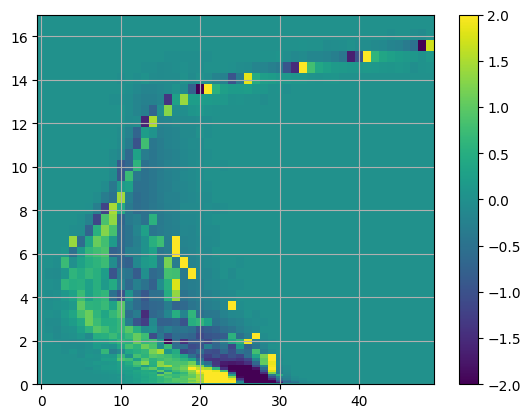

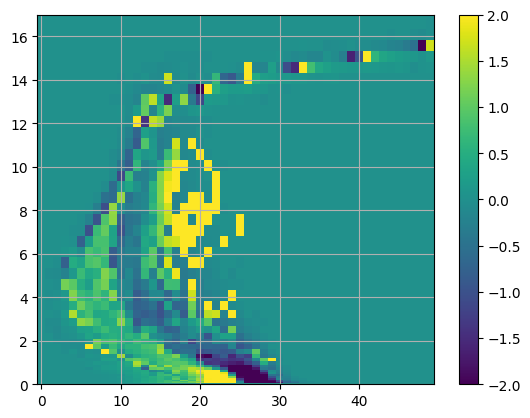

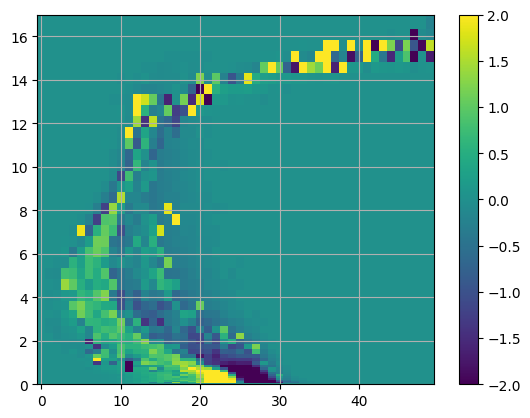

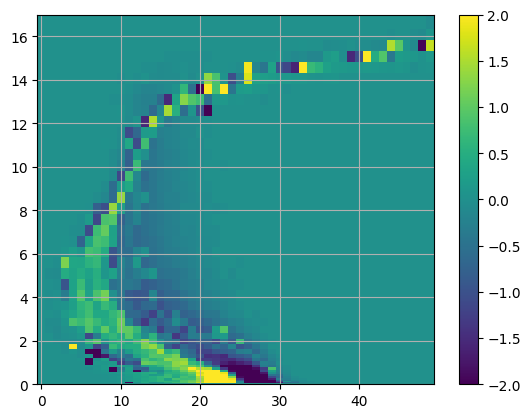

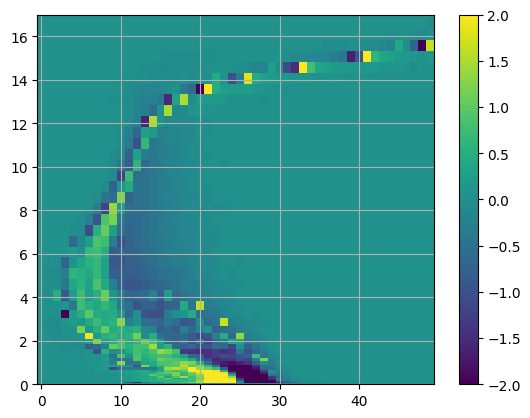

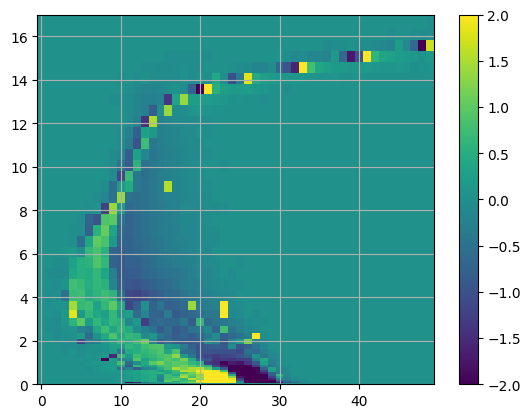

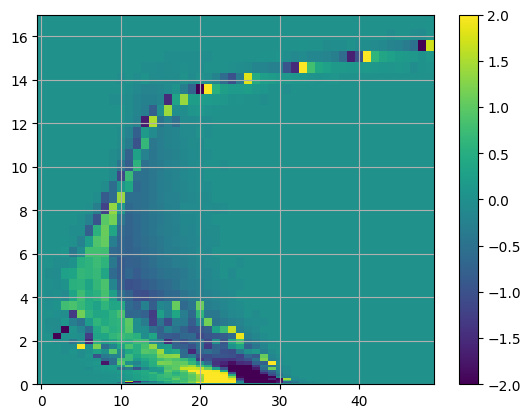

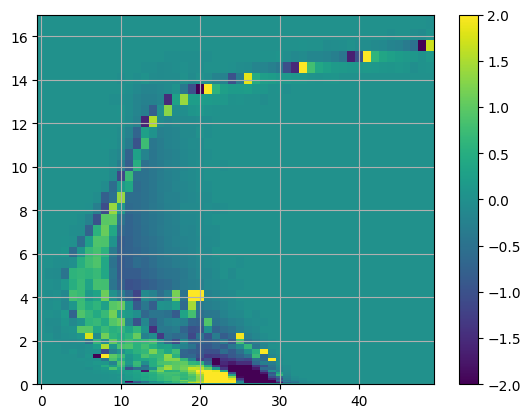

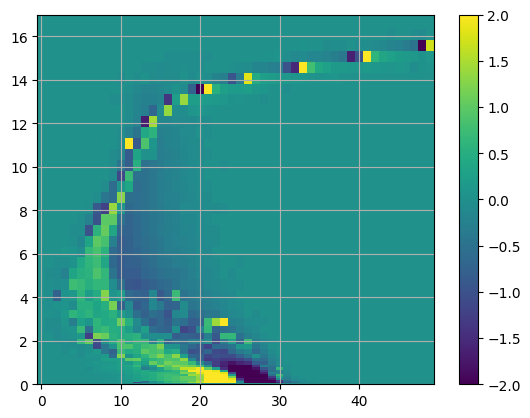

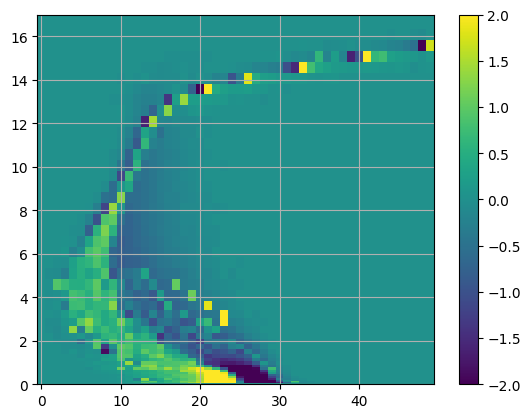

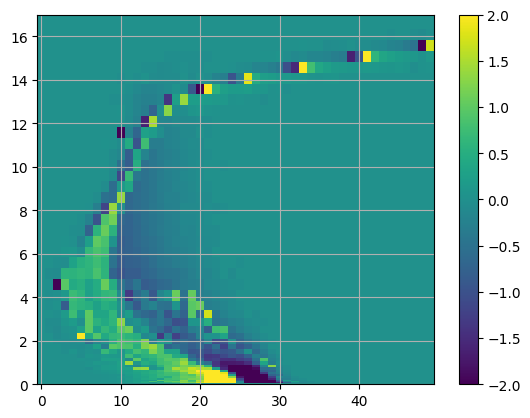

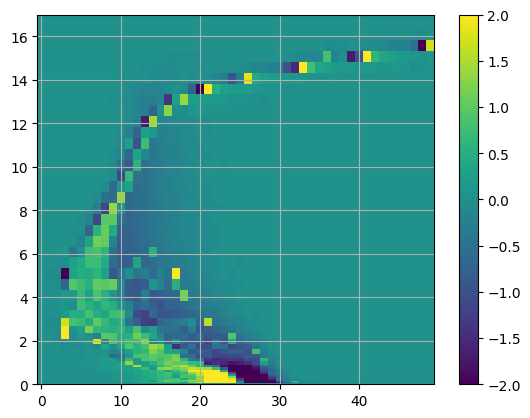

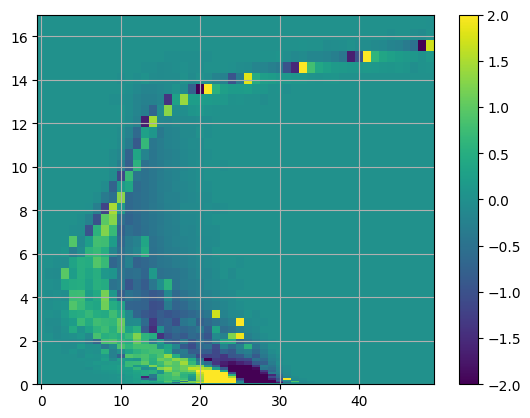

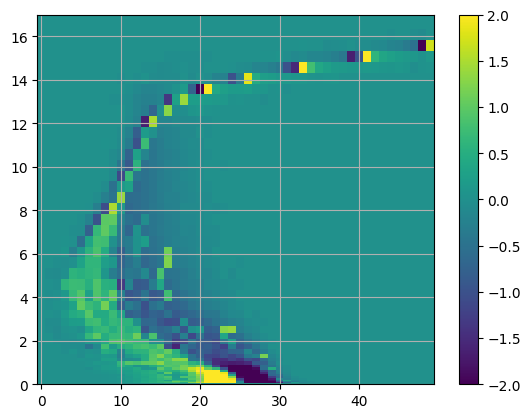

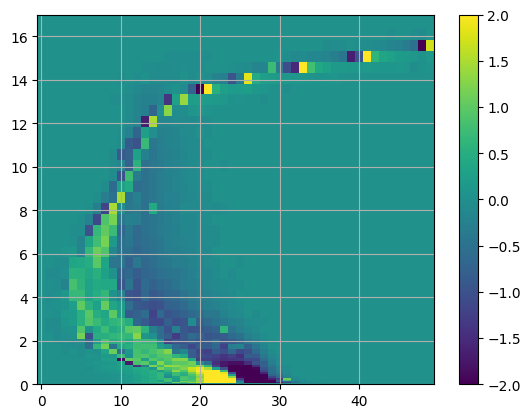

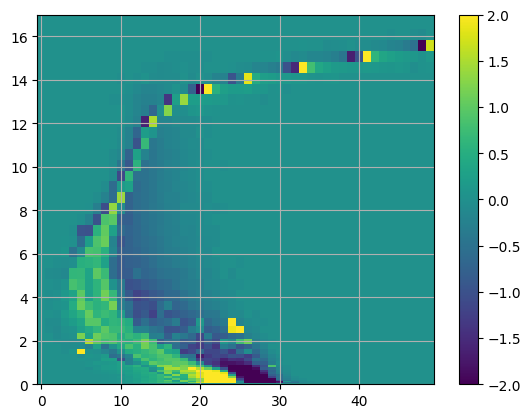

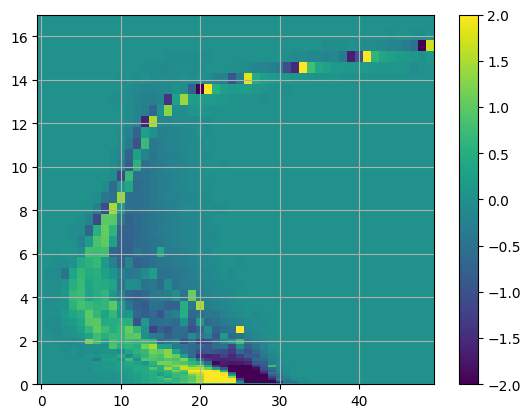

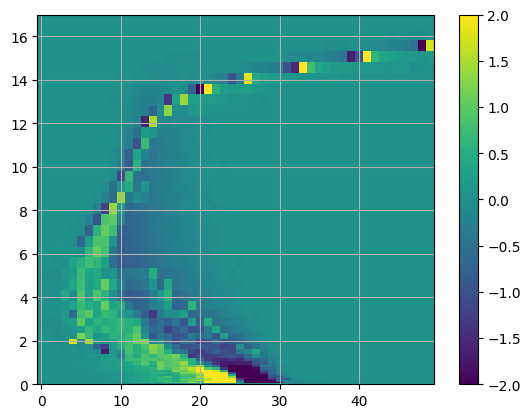

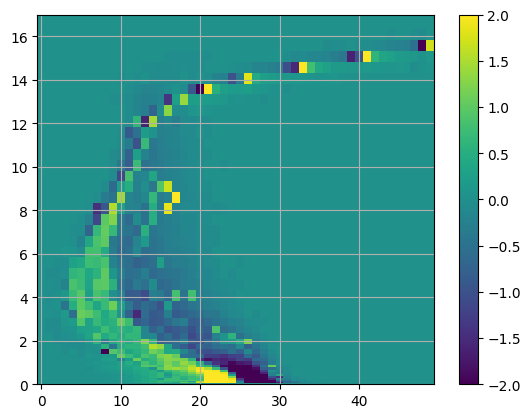

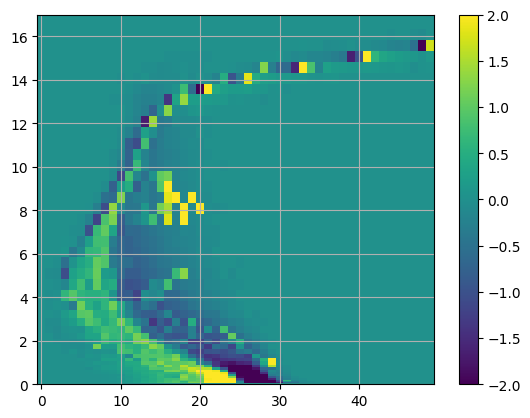

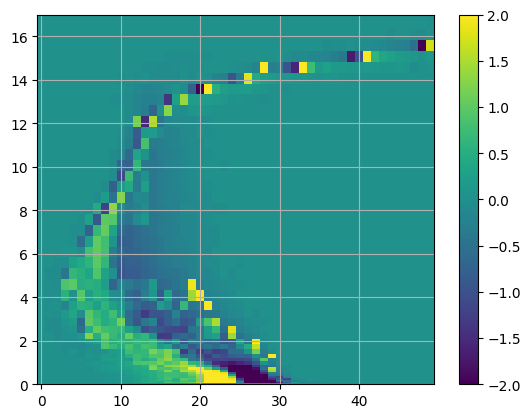

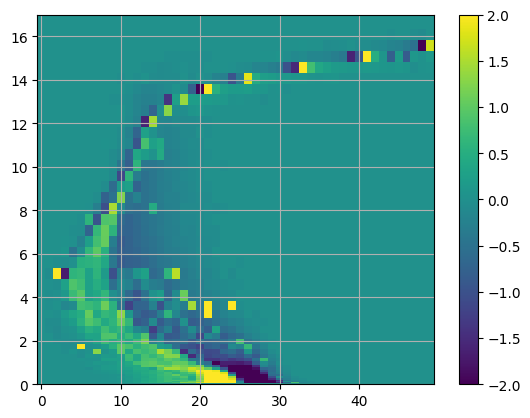

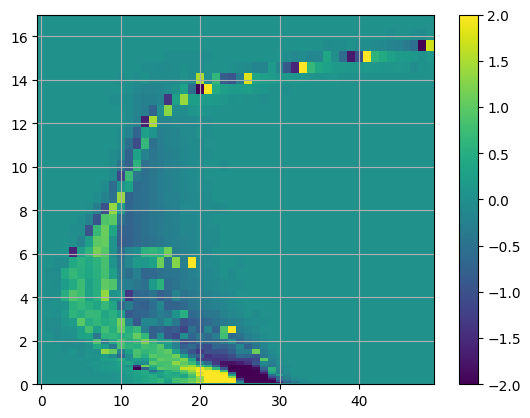

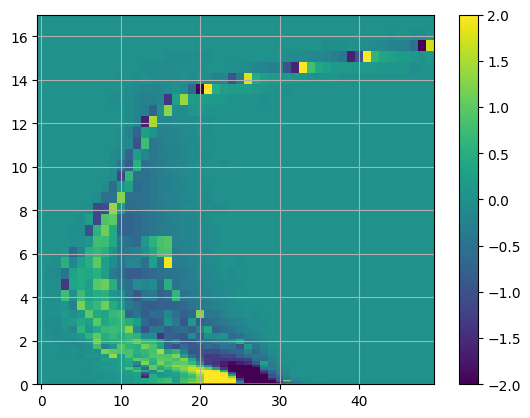

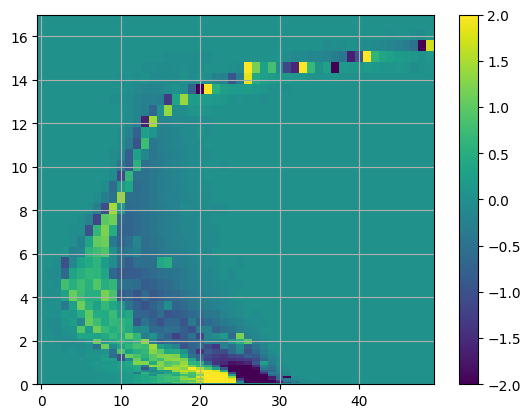

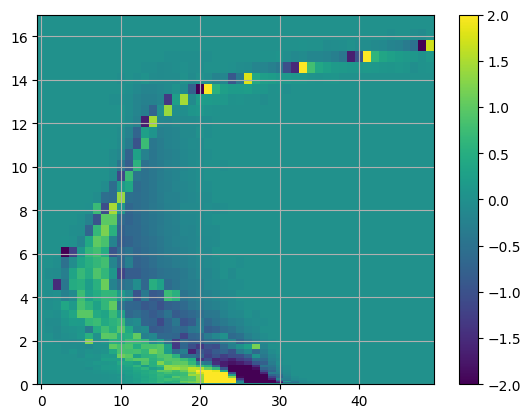

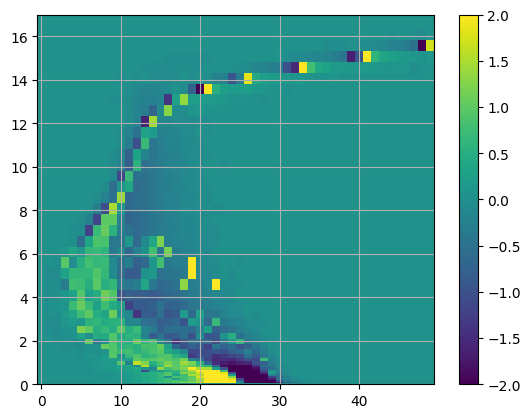

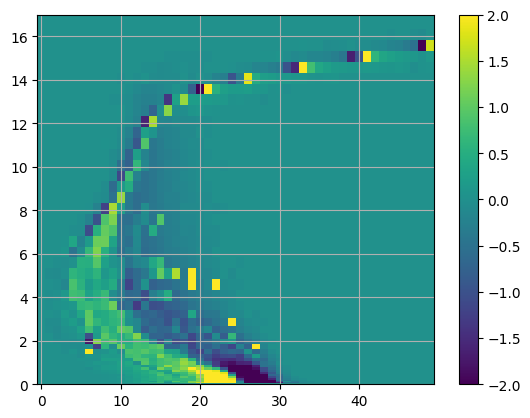

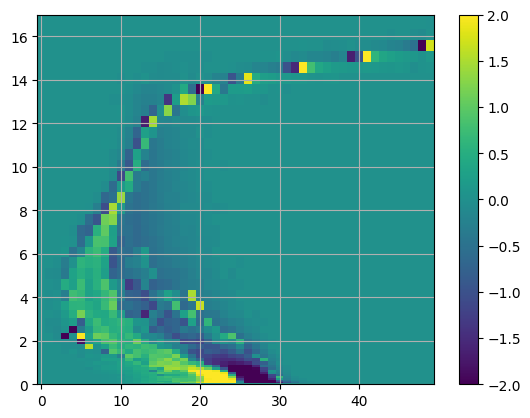

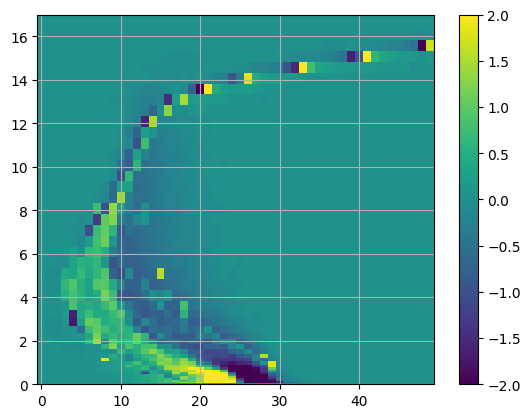

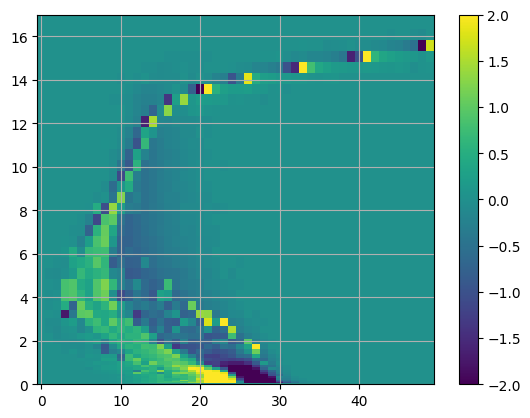

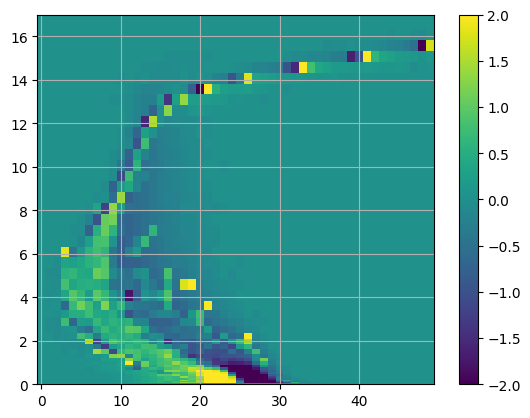

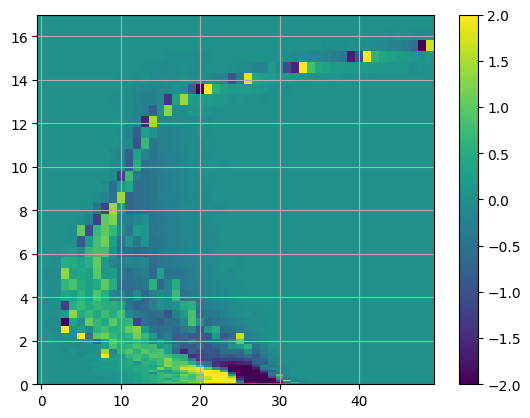

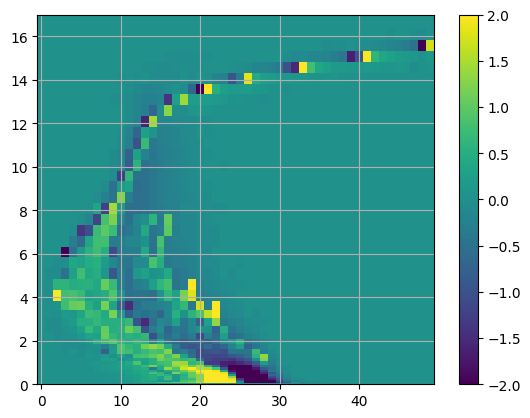

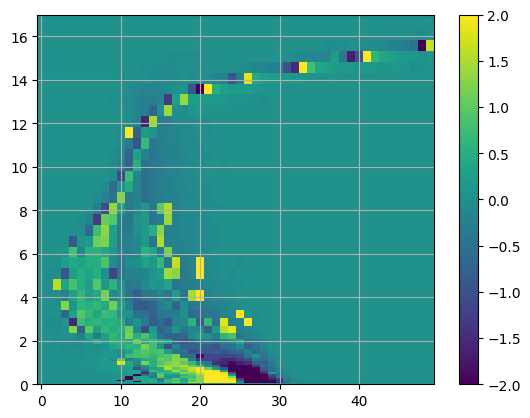

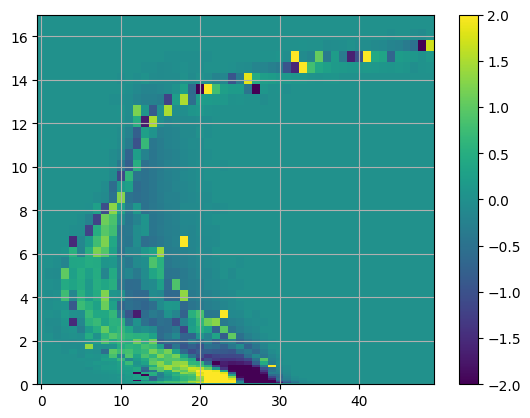

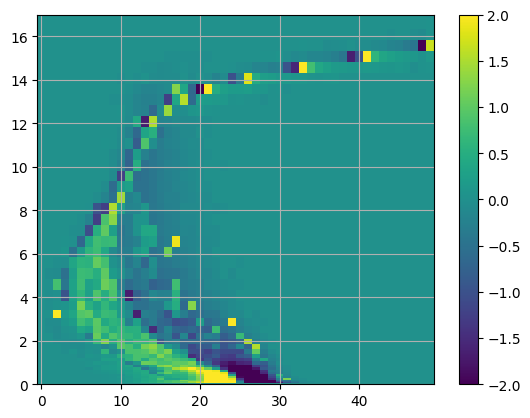

In [234]:
for i in range(50, 100):

    diag_reduced_window = diagnostic_fmse_z(
        fmse_array=fmse_sub,
        z_array=simu_list[0].dataset_3d.z.values,
        data_array=rho_w_sub,
        time_step=i,
        bin_mode='max'
    )
    """
    fmse = simu_list[0].dataset_isentropic.fmse.values
    z = simu_list[0].dataset_3d.z.values / 1000
    XX, ZZ = np.meshgrid(fmse, z)
    plt.pcolormesh(XX,ZZ, diag_before)
    plt.ylim(0,17)
    plt.grid(True)
    plt.show()
    """
    XX, ZZ = np.meshgrid(fmse, z)
    diag_reduced_window = np.nan_to_num(diag_reduced_window)
    plt.pcolormesh(XX,ZZ, (diag_reduced_window-mean_diag)/std_diag, vmin=-2, vmax=2)
    plt.ylim(0,17)
    plt.colorbar()
    plt.grid(True)
    plt.show()

In [64]:
mean_diag = np.mean(all_diag_reduced_window, axis=0)
std_diag = np.std(all_diag_reduced_window, axis=0)
std_diag[std_diag==0]=0.00001
norm_data = (all_diag_reduced_window-mean_diag)/std_diag

In [65]:
norm_data.shape

(480, 64, 50)

In [66]:
norm_data = norm_data.reshape(norm_data.shape[0], -1)

In [67]:
norm_data.shape

(480, 3200)

In [76]:
aaa = (all_diag_reduced_window-mean_diag)/std_diag

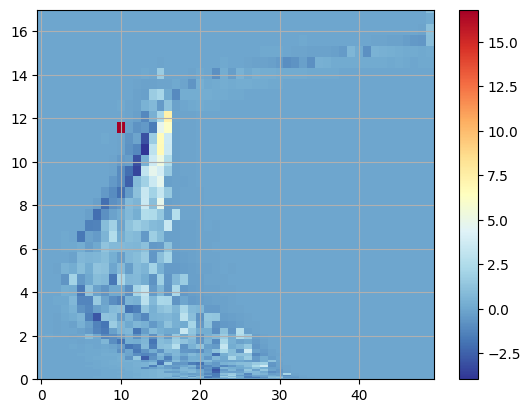

In [104]:
fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,ZZ = np.meshgrid(fmse, z)
plt.pcolormesh(XX,ZZ, aaa[100], cmap='RdYlBu_r')#, vmin=-10, vmax=10)
plt.colorbar()
plt.grid(True)
plt.ylim(0,17)
#plt.clim(-2,2)
plt.show()

In [87]:
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_components = 3  # Choose how many components you want to keep
pca = PCA(n_components=n_components)
all_diag_pca = pca.fit_transform(norm_data.T)  # Convert to numpy for sklearn PCA

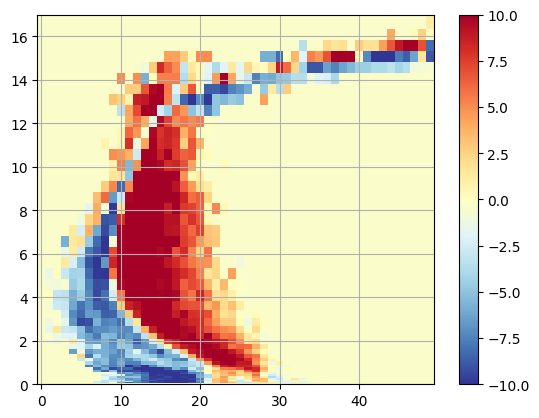

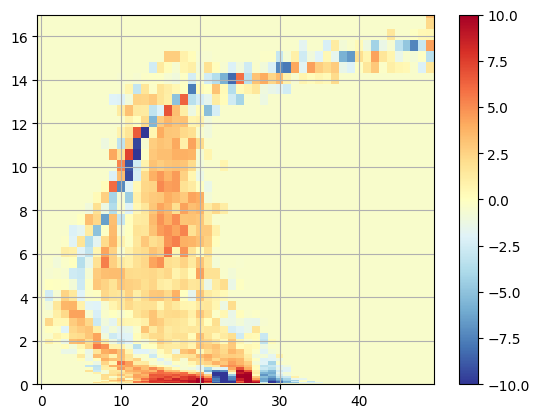

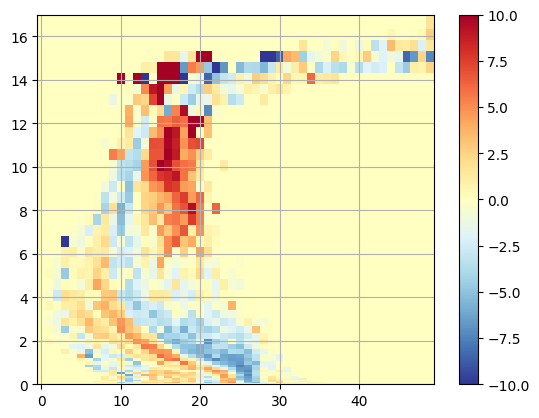

In [ ]:
for i in range(n_components):    
    
    fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
    XX,ZZ = np.meshgrid(fmse, z)
    plt.pcolormesh(XX,ZZ, all_diag_pca[:,i].reshape(64,50), cmap='RdYlBu_r', vmin=-10, vmax=10)
    plt.colorbar()
    plt.grid(True)
    plt.ylim(0,17)
    #plt.clim(-2,2)
    plt.show()


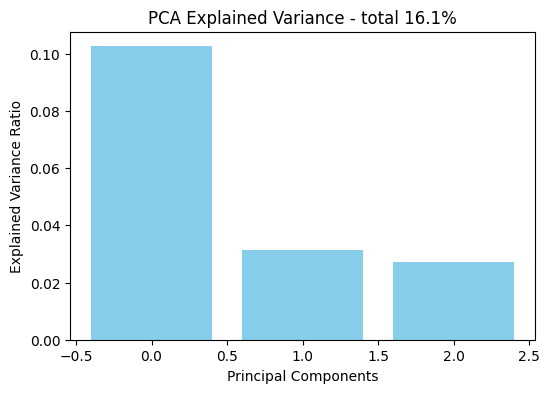

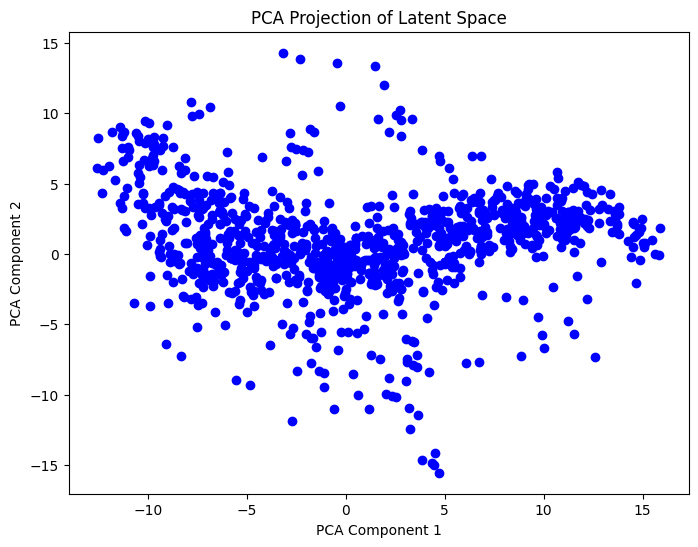

In [97]:
# Optional: Visualize the explained variance ratio
plt.figure(figsize=(6,4))
plt.bar(range(n_components), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel(f'Explained Variance Ratio')
plt.title(f'PCA Explained Variance - total {100*np.round(pca.explained_variance_ratio_.cumsum()[-1],3)}%')
plt.show()

# Visualizing PCA projections (for example, using the first 2 components)
plt.figure(figsize=(8,6))
plt.scatter(all_diag_pca[:, 0], all_diag_pca[:, 1], c='b', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Latent Space')
plt.show()

# You can now use 'all_mu_pca' for further analysis or processing.
